In [14]:
using Plots # you should really use Makie but that's for later
using Random
using StatsBase

In [15]:
# simulate one time step of the branching process
# offspring_func : function that randomly generates number of offspring for one individual
function step_bp(pop_size, offspring_func, death_rate_t)
	new_pop_size = 0
	for _ in 1:pop_size
        if death_func(death_rate_t) == 1
		    new_pop_size += offspring_func(pop_size)
        end
	end
	return new_pop_size
end


#Okay Now I don't want the population to stop growing because of a carrying capacity but because cell death rate increase exponentially with time
function death_func(death_rate)
	death_prob = [death_rate, 1 - death_rate] # probability of dying, and surviving
	return sample(0:length(death_prob)-1, ProbabilityWeights(death_prob))
end

function death_rate(t, a=0.009, c=0)
	# death rate follows a linear pattern dependant of time : at+c
	return a*t+c
end

function new_offspring_func(pop_size)
	offspring_prob = [0.9, 0.1] # probability of staying put and dividing
	return sample(1:length(offspring_prob), ProbabilityWeights(offspring_prob))
end

function simulate_bp(steps, offspring_func)
	bp = zeros(steps)
	bp[1] = 1
	for t in 2:steps
		death_rate_t = death_rate(t)
		bp[t] = step_bp(bp[t-1], offspring_func, death_rate_t)#ici on regarde la population à t-1 donc ici on fix pop_size=1 à t=0
        if bp[t] == 0
            print("Everyone died :( in ", t, " time steps")
            break
        end
	end
	return bp
end

simulate_bp (generic function with 2 methods)

In [16]:
# simulate 10 independent branching processes
bps = [simulate_bp(100, const_offspring_func) for _ in 1:10];
plot(bps, label=nothing) # these explode or go extinct


UndefVarError: UndefVarError: `const_offspring_func` not defined

Actually this seems trivial but make sens for what we are trying to model. When we look at HSC transplantation often you have an initial increase but then graft fails because the number of "young MPP" is not growing fast enough and so eventually differientated cell population crash after a few weeks even if there is a "burst" of new cells right after transplant

So now what if we tried to implement self renewal in this process death rate is dependant of cells' age and not of the system's age. The goal is to reach a stable state.

In [17]:
#Thus we define a cells repertory which keeps track of cell ages (2 arrays one with ID the other with age)
#We must define a function which create new young cells at random time
function population_init(nbr_cells)
    cells_id = collect(1:nbr_cells) #array of integers from 1 to nbr_cells
    cells_age = zeros(nbr_cells)
    return [cells_id, cells_age]
end

function new_offspring_func()
	offspring_prob = [0.9, 0.1] # probability of staying put and dividing
	return sample(1:length(offspring_prob), ProbabilityWeights(offspring_prob))
end


function cells_creation(creation_rate)
    sample(0:1, ProbabilityWeights([1 - creation_rate, creation_rate]))
end

function death_func(age, a=0.009, c=0)
    death_rate = a * age + c
	death_prob = [death_rate, 1 - death_rate] # probability of dying, and surviving
	return sample(0:length(death_prob)-1, ProbabilityWeights(death_prob))
end

function step_bp_2(tot_cells, cells_id, cells_age, offspring_func, creation_rate)
    new_cells = []
    dead_cells = []
    pop_size = length(cells_id)
	for i in 1:pop_size
        age = cells_age[i]
        if death_func(age) == 1
		    if offspring_func(pop_size) == 1
                cells_age[i] += 1
            else
                append!(new_cells,[age + 1, age + 1])
                append!(dead_cells, i)
            end  
        else
            append!(dead_cells, i)
        end
	end

    if cells_creation(creation_rate) == 1
        append!(new_cells, 0)
    end

    #print("dead_cells = ", dead_cells, " new_cells = ", new_cells)
    deleteat!(cells_id, dead_cells) 
    deleteat!(cells_age, dead_cells)

    append!(cells_id, (tot_cells + 1):(tot_cells + length(new_cells)))
    append!(cells_age, new_cells)
    #print("cells_id = ", cells_id, " cells_age = ", cells_age)
	return cells_id, cells_age, length(new_cells), length(dead_cells)
end



function simulate_bp(steps, offspring_func, nbr_cells_0, creation_rate)
	extinction = 550 
    bp = zeros(steps)
    nbr_dead = 0
    tot_cells = nbr_cells_0
	bp[1] = nbr_cells_0

    cells_id, cells_age = population_init(nbr_cells_0)

	for t in 2:steps
		cells_id, cells_age, new_cells, dead_cells = step_bp_2(tot_cells, cells_id, cells_age, offspring_func, creation_rate)#ici on regarde la population à t-1 donc ici on fix pop_size=1 à t=0
        bp[t] = length(cells_id)
        tot_cells += new_cells
        nbr_dead += dead_cells
        if bp[t] == 0
            extinction = t
            break
        end
	end
	return [bp, extinction]
end

simulate_bp (generic function with 2 methods)

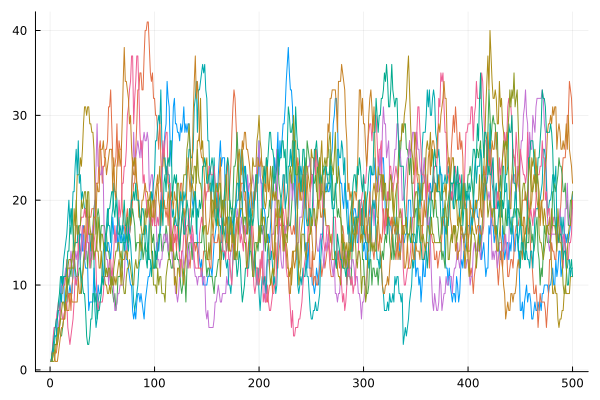

In [18]:
Random.seed!(6)

bps = [simulate_bp(500, new_offspring_func, 1, 0.5) for _ in 1:10];
cells = [vector[1] for vector in bps];
plot(cells, label=nothing) # these explode or go extinct

So we see a different behavior when the death rates becomes age dependant and not time dependant and that a new cell of age 0 appear with probability creation_rate at each time step.

This corresponds to what we expected. Yeah !!!

Now we are going to try to asses the relationship between creation_rate and extinction_frequency.

In [19]:
extinction_time = [vector[2] for vector in bps]
cells = [vector[1] for vector in bps]

10-element Vector{Vector{Float64}}:
 [1.0, 2.0, 3.0, 4.0, 4.0, 4.0, 7.0, 7.0, 7.0, 9.0  …  13.0, 15.0, 16.0, 15.0, 16.0, 15.0, 16.0, 17.0, 18.0, 21.0]
 [1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 6.0, 7.0  …  25.0, 25.0, 25.0, 27.0, 30.0, 30.0, 34.0, 33.0, 32.0, 29.0]
 [1.0, 1.0, 2.0, 3.0, 3.0, 3.0, 5.0, 5.0, 5.0, 4.0  …  21.0, 21.0, 22.0, 19.0, 20.0, 17.0, 18.0, 20.0, 20.0, 19.0]
 [1.0, 2.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 8.0  …  16.0, 15.0, 19.0, 19.0, 22.0, 18.0, 17.0, 17.0, 18.0, 20.0]
 [1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.0, 6.0  …  7.0, 9.0, 10.0, 9.0, 9.0, 9.0, 9.0, 11.0, 11.0, 11.0]
 [1.0, 1.0, 2.0, 3.0, 4.0, 4.0, 6.0, 7.0, 7.0, 9.0  …  18.0, 16.0, 15.0, 12.0, 12.0, 13.0, 13.0, 11.0, 12.0, 12.0]
 [1.0, 2.0, 4.0, 5.0, 5.0, 6.0, 7.0, 8.0, 7.0, 7.0  …  12.0, 16.0, 15.0, 14.0, 13.0, 13.0, 15.0, 15.0, 16.0, 20.0]
 [1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 4.0  …  27.0, 26.0, 27.0, 29.0, 26.0, 30.0, 26.0, 25.0, 24.0, 22.0]
 [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 6.0, 8.0, 9.0, 11.

In [20]:
Random.seed!(6)
parameter = 0:0.05:1
extinction = []
for creation_rate in parameter
    bps = [simulate_bp(500, new_offspring_func, 1, creation_rate) for _ in 1:50];
    append!(extinction, [[vector[2] for vector in bps]]) 
end 

x=[]
for i in parameter
    append!(x, [[i for _ in 1:50]])
end

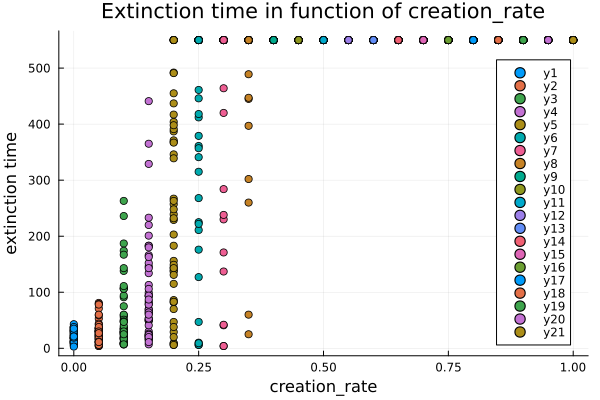

In [21]:

scatter(x, extinction, title = "Extinction time in function of creation_rate", xlabel = "creation_rate", ylabel = "extinction time")


In [22]:
#first we are going to implement categories of MPP and fully differien
#full differentiation probability follows a sigmoid pattern



Now we want to use the package Agent.jl to more efficiently model this behaviour.

In [28]:
using Agents 
using StatsBase
using Plots
using BenchmarkTools
using Statistics
using DataFrames
using TimerOutputs

First, we define 2 types of agent, which have different properties. But as stated in the documentation of Agent.jl, this might not be the more efficient way to make the model evolve.

It might be more efficient to define the type as a property, and create properties for this agent outside of the properties of each cell.

But for simplicity at first, we will model 2 types of agent each with differents properties:

HSC: the stem cell, which cannot die. They are quiescent or not, can leave auiescence to transition and also divide.

hemato_cell: These cells can die, their death rate depends of their age.

Both these type are NoSpaceAgent, meaning their minimal defimnitiom is am ID.

In [25]:
@agent HSC NoSpaceAgent begin
    quiescence::Bool # whether the agent is likely to divide True = quiescence
    age::Int
end

@agent hemato_cell NoSpaceAgent begin
    age::Int #Age of the cell since she left HSC in number of time step
    nbr_division::Int #nbr of divisions since the Cell left HSC
end

We then define a function to initialize the model. The ABM() function creates a model which considers both type of agents we just created.

Operation on the cells are executed by type, starting with HSC, inside of a type it is done at random.

We start by creating quiescent HSC of age 0.

In [32]:
function initialize_model(nbr_HSC)
    properties = Dict(:Time => 0)
    space = nothing 
    life = ABM(Union{HSC, hemato_cell}, space, scheduler = Schedulers.ByType(false, true, Union{HSC, hemato_cell}); properties)

    first_agents = HSC.(1:nbr_HSC, trues(nbr_HSC), zeros(nbr_HSC))
    for cell in first_agents
        add_agent!(cell, life)
    end
    return life
end

initialize_model (generic function with 1 method)

Then we define function which are HSC specific (we call function with the same name and depending if the cell is HSC or hemato_cell, the operations are different).

division: HSC here divide at a steady rate

activation: HSCs which are quiescent become active at a steady rate

transition: HSCs which are active transition at a steady rate

During a time step, quiescent cell can activate and active cells can transition, all HSCs can divide at a steady rate

In [26]:
function division!(cell::HSC, model; division_rate = 0.5)
    if sample(0:1, ProbabilityWeights([(1 - division_rate), division_rate])) == 1
        
        add_agent!(HSC, model, cell.quiescence, cell.age)
        add_agent!(HSC, model, cell.quiescence, cell.age)
        remove_agent!(cell, model)
    end
end

function cell_activation!(cell::HSC, activation_rate)
    if sample(0:1, ProbabilityWeights([1 - activation_rate, activation_rate])) == 1
        cell.quiescence = false  
    end
end

function cell_transition!(cell::HSC, model, transition_rate)
    if sample(0:1, ProbabilityWeights([1 - transition_rate, transition_rate])) == 1
        add_agent!(hemato_cell, model, 0, 0)
        remove_agent!(cell, model)
    end
end

function life_step!(cell::HSC, model)
    
    if cell.quiescence == true
        cell.age += 1 
        cell_activation!(cell, 0.02)
    else
        cell_transition!(cell, model, 1)
    end
    if typeof(cell) == HSC
        division!(cell, model; division_rate = 0.5)
    end
end

life_step! (generic function with 1 method)

Hemato cells can divide, their division rate is here linearly dependant of the age of the cells.

At each step, a cell can either die or survive, if the cell survives it can divide at a steady rate and their age will increase of 1.

In [27]:
function division!(cell::hemato_cell, model; division_rate = 0.3)
    
    if sample(0:1, ProbabilityWeights([(1 - division_rate), division_rate])) == 1
        divisions = cell.nbr_division + 1

        add_agent!(hemato_cell, model, cell.age, divisions)
        add_agent!(hemato_cell, model, cell.age, divisions)
        remove_agent!(cell, model)
    end
end

function death_func(age, a=0.009, c=0)
    death_rate = a * age + c
	death_prob = [death_rate, 1 - death_rate]
    #print(death_prob) probability of dying, and surviving
	return sample(0:1, ProbabilityWeights(death_prob))
end

function life_step!(cell::hemato_cell, model)
    
    if death_func(cell.age) == 1 #in case of survival
        division_rate = 0.3
        cell.age += 1
        division!(cell, model; division_rate)
    else
        remove_agent!(cell, model)     
    end
    
end

life_step! (generic function with 2 methods)

We then want to run the model for a given number of steps, and record meaningful data of the agents and also of the model. For now we don't record information at the model level, just agents. But we will add later count of each type cell and global time of the model, 

┌ Warning: Agent type is not concrete. If your agent is parametrically typed, you're probably
│ seeing this warning because you gave `Agent` instead of `Agent{Float64}`
│ (for example) to this function. You can also create an instance of your agent
│ and pass it to this function. If you want to use `Union` types for mixed agent
│ models, you can silence this warning.
└ @ Agents C:\Users\ambre\.julia\packages\Agents\06AXy\src\core\model_concrete.jl:139


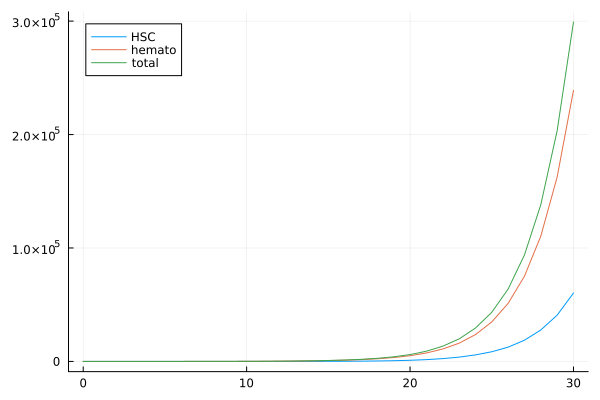

In [35]:
#we define functions to count the number of cells of each type
hsc(a) = typeof(a) == HSC
hemato(a) = typeof(a) == hemato_cell
adata = [(hsc, count), (hemato, count)]

#to = TimerOutput()
#df = DataFrame(step =[0], count_hsc =[0], count_hemato = [0])

#for n_steps in [1,10,20,30,40,45]
#@timeit to ("loop"*string(n_steps)) begin 
n_steps = 30
life = initialize_model(1)
data,_ = run!(life, life_step!, n_steps; adata)  
#end
#append!(df, data)
#end
#print(df)
#show(to)
plot(data.step, [data.count_hemato, data.count_hsc, data.count_hemato + data.count_hsc], labels =["HSC" "hemato" "total"])

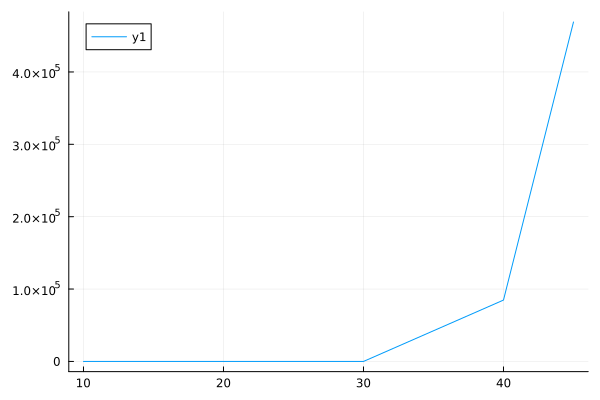

In [31]:
# the Run time given different number of step (commented lines of codes above) was assessed and we see that in the case of an almost exponential growth of the number of cells,

time = [2.19, 5.50, 3.67, 84800, 469000]
step = [10, 20,30,40,45]
nbr_tot_max_cells = [32, 2064 + 452, 15013081237 + 3528616, 34463517 + 9299582]
plot(step, time)

#runtime becomes a problem when we reach tens of millions of cells, it seems that it will be possible to model around 10 millions of cells
#runtime must be monitored closely each time we had new features